In [1]:
import os, json, cv2, numpy as np, matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F

import albumentations as A # Library for augmentations

# change the number of keypoints in cocotools

C:\Users\CallumMacpherson\anaconda3\envs\park\Lib\site-packages\pycocotools

# 1. Imports

In [2]:
# https://github.com/pytorch/vision/tree/main/references/detection
import transforms, utils, engine, train
from utils import collate_fn
from engine import train_one_epoch, evaluate

# 2. Augmentations

In [3]:

def train_transform():
    return A.Compose([
        A.Sequential([
            A.RandomRotate90(p=1), # Random rotation of an image by 90 degrees zero or more times
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, brightness_by_max=True, always_apply=False, p=1), # Random change of brightness & contrast
        ], p=1)
    ],
    keypoint_params=A.KeypointParams(format='xy'), # More about keypoint formats used in albumentations library read at https://albumentations.ai/docs/getting_started/keypoints_augmentation/
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels']) # Bboxes should have labels, read more at https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
    )

# 3. Dataset Class

In [4]:
class ClassDataset(Dataset):
    def __init__(self, root, transform=None, demo=False):                
        self.root = root
        self.transform = transform
        self.demo = demo # Use demo=True if you need transformed and original images (for example, for visualization purposes)
        self.imgs_files = sorted(os.listdir(os.path.join(root, "images")))
        self.annotations_files = sorted(os.listdir(os.path.join(root, "annotations")))
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs_files[idx])
        annotations_path = os.path.join(self.root, "annotations", self.annotations_files[idx])

        img_original = cv2.imread(img_path)
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)        
        
        with open(annotations_path) as f:
            data = json.load(f)
            bboxes_original = data['bboxes']
            keypoints_original = data['keypoints']
            
            # All objects are glue tubes
            bboxes_labels_original = ['Glue tube' for _ in bboxes_original]            

        if self.transform:   
            # Converting keypoints from [x,y,visibility]-format to [x, y]-format + Flattening nested list of keypoints            
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]], where each keypoint is in [x, y]-format            
            # Then we need to convert it to the following list:
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2]
            keypoints_original_flattened = [el[0:2] for kp in keypoints_original for el in kp]
            
            # Apply augmentations
            transformed = self.transform(image=img_original, bboxes=bboxes_original, bboxes_labels=bboxes_labels_original, keypoints=keypoints_original_flattened)
            img = transformed['image']
            bboxes = transformed['bboxes']
            
            # Unflattening list transformed['keypoints']
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2], where each keypoint is in [x, y]-format
            # Then we need to convert it to the following list:
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]]
            keypoints_transformed_unflattened = np.reshape(np.array(transformed['keypoints']), (-1,2,2)).tolist()

            # Converting transformed keypoints from [x, y]-format to [x,y,visibility]-format by appending original visibilities to transformed coordinates of keypoints
            keypoints = []
            for o_idx, obj in enumerate(keypoints_transformed_unflattened): # Iterating over objects
                obj_keypoints = []
                for k_idx, kp in enumerate(obj): # Iterating over keypoints in each object
                    # kp - coordinates of keypoint
                    # keypoints_original[o_idx][k_idx][2] - original visibility of keypoint
                    obj_keypoints.append(kp + [keypoints_original[o_idx][k_idx][2]])
                keypoints.append(obj_keypoints)
        
        else:
            img, bboxes, keypoints = img_original, bboxes_original, keypoints_original        
        
        # Convert everything into a torch tensor        
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)       
        target = {}
        target["boxes"] = bboxes
        target["labels"] = torch.as_tensor([1 for _ in bboxes], dtype=torch.int64) # all objects are glue tubes
        target["image_id"] = torch.tensor([idx])
        target["area"] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        target["iscrowd"] = torch.zeros(len(bboxes), dtype=torch.int64)
        target["keypoints"] = torch.as_tensor(keypoints, dtype=torch.float32)        
        img = F.to_tensor(img)
        
        bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)
        target_original = {}
        target_original["boxes"] = bboxes_original
        target_original["labels"] = torch.as_tensor([1 for _ in bboxes_original], dtype=torch.int64) # all objects are glue tubes
        target_original["image_id"] = torch.tensor([idx])
        target_original["area"] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
        target_original["iscrowd"] = torch.zeros(len(bboxes_original), dtype=torch.int64)
        target_original["keypoints"] = torch.as_tensor(keypoints_original, dtype=torch.float32)        
        img_original = F.to_tensor(img_original)

        if self.demo:
            return img, target, img_original, target_original
        else:
            return img, target
    
    def __len__(self):
        return len(self.imgs_files)

# 4. Visualizing a random item from the dataset

In [5]:
KEYPOINTS_FOLDER_TRAIN = 'glue_tubes_keypoints_dataset_134imgs (1)/train'
dataset = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=True)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

iterator = iter(data_loader)
batch = next(iterator)

print("Original targets:\n", batch[3], "\n\n")
print("Transformed targets:\n", batch[1])

Original targets:
 ({'boxes': tensor([[206., 440., 638., 720.]]), 'labels': tensor([1]), 'image_id': tensor([37]), 'area': tensor([120960.]), 'iscrowd': tensor([0]), 'keypoints': tensor([[[580., 667.,   1.],
         [241., 496.,   1.]]])},) 


Transformed targets:
 ({'boxes': tensor([[206., 440., 638., 720.]]), 'labels': tensor([1]), 'image_id': tensor([37]), 'area': tensor([120960.]), 'iscrowd': tensor([0]), 'keypoints': tensor([[[580., 667.,   1.],
         [241., 496.,   1.]]])},)


## 4.1 CJM Explore Dataloader

In [11]:
batch[0][0].shape

torch.Size([3, 1080, 1920])

In [15]:
batch[1]

({'boxes': tensor([[206., 440., 638., 720.]]),
  'labels': tensor([1]),
  'image_id': tensor([37]),
  'area': tensor([120960.]),
  'iscrowd': tensor([0]),
  'keypoints': tensor([[[580., 667.,   1.],
           [241., 496.,   1.]]])},)

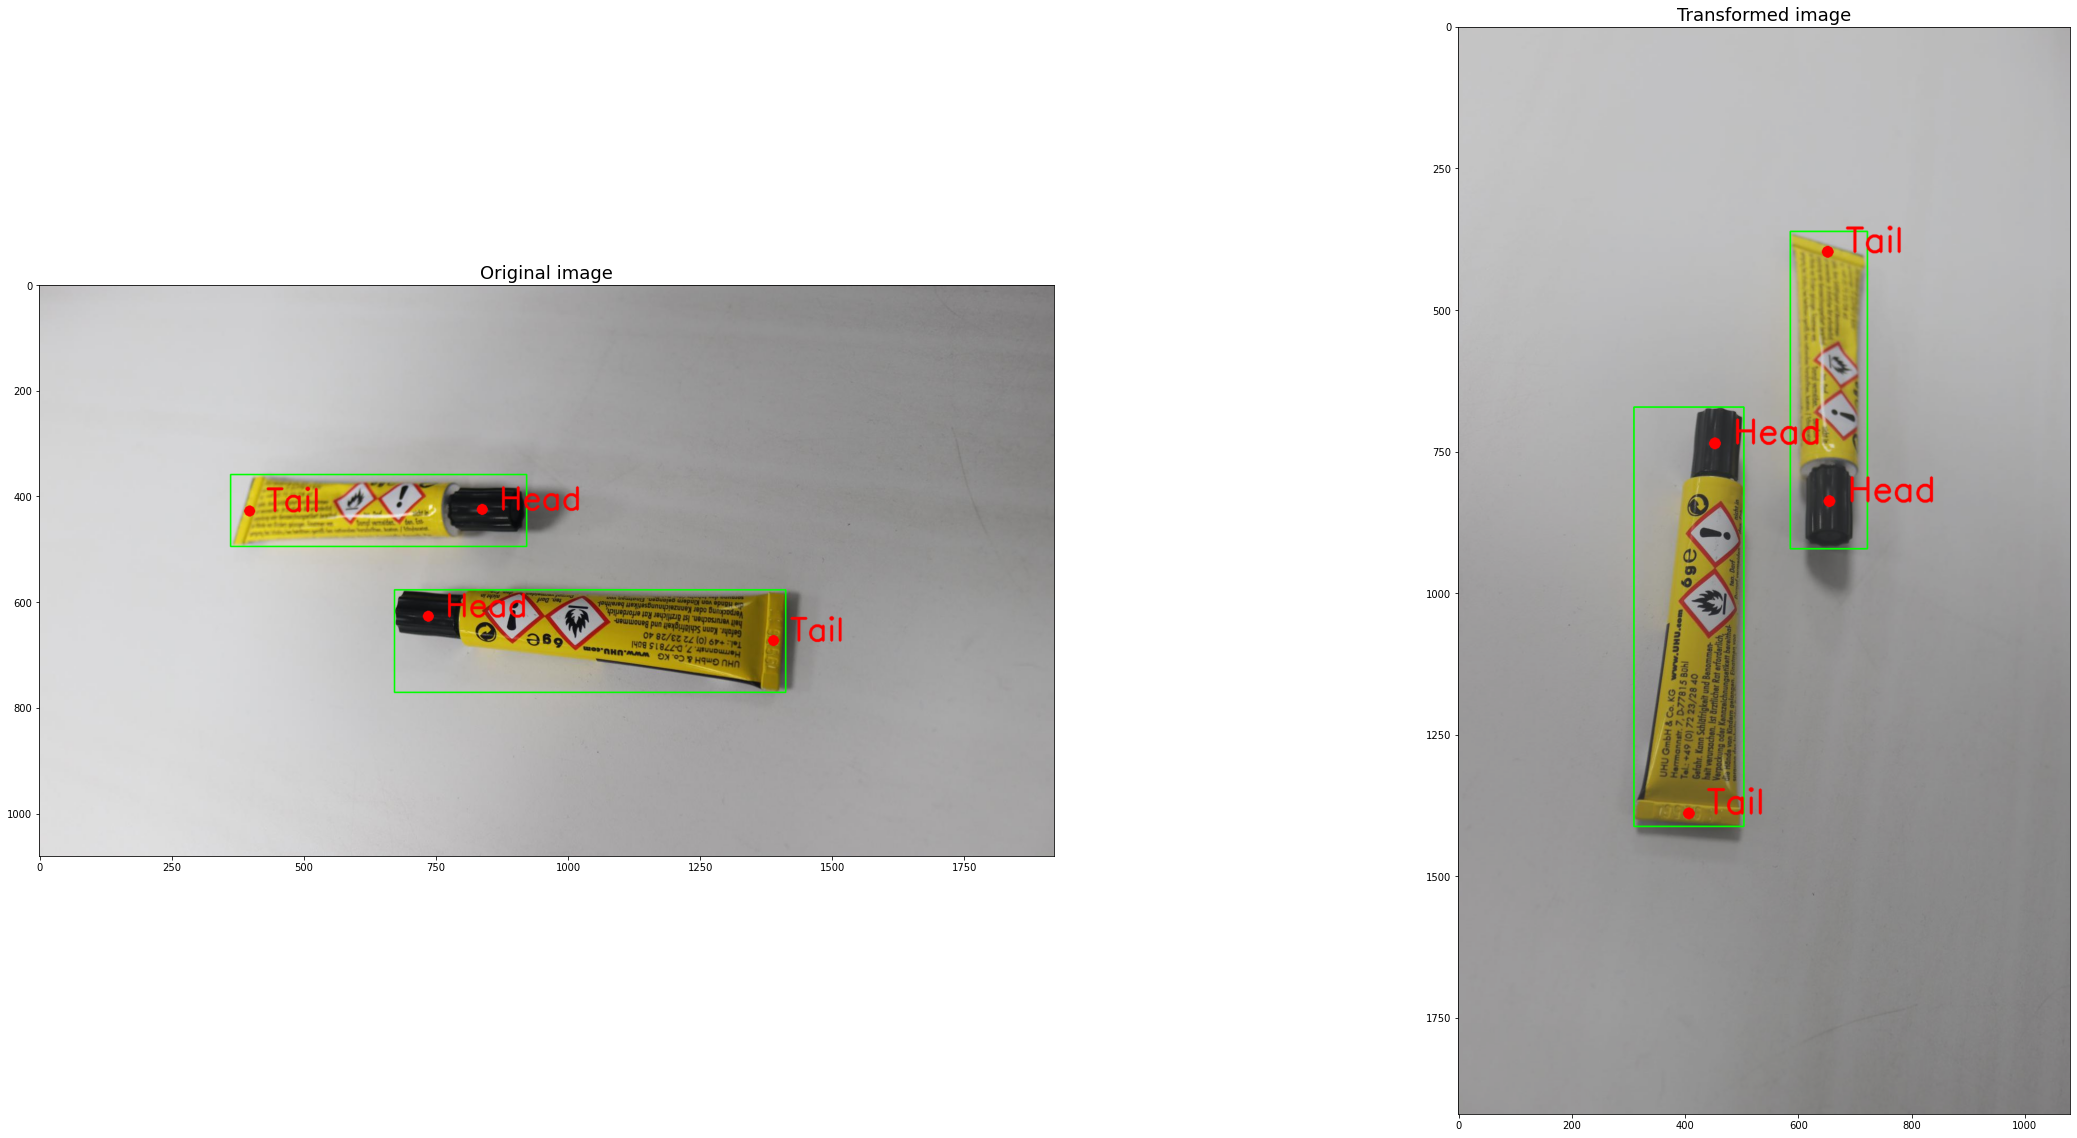

In [6]:
keypoints_classes_ids2names = {0: 'Head', 1: 'Tail'}

def visualize(image, bboxes, keypoints, image_original=None, bboxes_original=None, keypoints_original=None):
    fontsize = 18

    for bbox in bboxes:
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)
    
    for kps in keypoints:
        for idx, kp in enumerate(kps):
            image = cv2.circle(image.copy(), tuple(kp), 5, (255,0,0), 10)
            image = cv2.putText(image.copy(), " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

    if image_original is None and keypoints_original is None:
        plt.figure(figsize=(40,40))
        plt.imshow(image)

    else:
        for bbox in bboxes_original:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)
        
        for kps in keypoints_original:
            for idx, kp in enumerate(kps):
                image_original = cv2.circle(image_original, tuple(kp), 5, (255,0,0), 10)
                image_original = cv2.putText(image_original, " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

        f, ax = plt.subplots(1, 2, figsize=(40, 20))

        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)
        
image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints = []
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp[:2] for kp in kps])

image_original = (batch[2][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes_original = batch[3][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints_original = []
for kps in batch[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints_original.append([kp[:2] for kp in kps])

visualize(image, bboxes, keypoints, image_original, bboxes_original, keypoints_original)

# 5. Training

In [7]:
def get_model(num_keypoints, weights_path=None):
    
    anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0))
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
                                                                   pretrained_backbone=True,
                                                                   num_keypoints=num_keypoints,
                                                                   num_classes = 2, # Background is the first class, object is the second class
                                                                   rpn_anchor_generator=anchor_generator)

    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)        
        
    return model

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

KEYPOINTS_FOLDER_TRAIN = 'glue_tubes_keypoints_dataset_134imgs (1)/train'
KEYPOINTS_FOLDER_TEST = 'glue_tubes_keypoints_dataset_134imgs (1)/test'

dataset_train = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=False)
dataset_test = ClassDataset(KEYPOINTS_FOLDER_TEST, transform=None, demo=False)

data_loader_train = DataLoader(dataset_train, batch_size=1, shuffle=True, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

model = get_model(num_keypoints = 2)
model.to(device)


params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)
num_epochs = 5

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=1000)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device)
    


cuda
Epoch: [0]  [  0/111]  eta: 0:05:27  lr: 0.000010  loss: 9.3904 (9.3904)  loss_classifier: 0.5571 (0.5571)  loss_box_reg: 0.0386 (0.0386)  loss_keypoint: 8.0823 (8.0823)  loss_objectness: 0.6912 (0.6912)  loss_rpn_box_reg: 0.0211 (0.0211)  time: 2.9547  data: 0.0671  max mem: 1276
Epoch: [0]  [110/111]  eta: 0:00:00  lr: 0.001000  loss: 6.4099 (7.7419)  loss_classifier: 0.1148 (0.1634)  loss_box_reg: 0.1302 (0.0691)  loss_keypoint: 6.0874 (7.1012)  loss_objectness: 0.0577 (0.3956)  loss_rpn_box_reg: 0.0130 (0.0126)  time: 0.4451  data: 0.0666  max mem: 1845
Epoch: [0] Total time: 0:00:50 (0.4510 s / it)
creating index...
index created!
Test:  [ 0/23]  eta: 0:00:05  model_time: 0.1802 (0.1802)  evaluator_time: 0.0100 (0.0100)  time: 0.2503  data: 0.0562  max mem: 1845
Test:  [22/23]  eta: 0:00:00  model_time: 0.1885 (0.1955)  evaluator_time: 0.0060 (0.0061)  time: 0.2626  data: 0.0564  max mem: 1845
Test: Total time: 0:00:06 (0.2630 s / it)
Averaged stats: model_time: 0.1885 (0.195

FileNotFoundError: [Errno 2] No such file or directory: '/path/to/folder/where/to/save/model/weights/keypointsrcnn_weights.pth'

In [9]:
# Save model weights after training
torch.save(model.state_dict(), 'weights_demo/keypointsrcnn_weights.pth')

# 6. Visualizing model predictions

In [10]:
iterator = iter(data_loader_test)
images, targets = next(iterator)
images = list(image.to(device) for image in images)

with torch.no_grad():
    model.to(device)
    model.eval()
    output = model(images)

print("Predictions: \n", output)

Predictions: 
 [{'boxes': tensor([[ 596.2283,  404.3434,  733.3638,  732.8119],
        [1044.4546,  321.0873, 1351.7047,  472.1318],
        [ 983.0616,  239.6199, 1372.1902,  478.2451],
        [ 545.9999,  332.2331,  782.1119,  749.4382]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8988, 0.7048, 0.1809, 0.1568], device='cuda:0'), 'keypoints': tensor([[[6.1266e+02, 6.7447e+02, 1.0000e+00],
         [6.9694e+02, 4.3388e+02, 1.0000e+00]],

        [[1.0595e+03, 3.5058e+02, 1.0000e+00],
         [1.2907e+03, 4.3113e+02, 1.0000e+00]],

        [[1.0599e+03, 3.5390e+02, 1.0000e+00],
         [1.0570e+03, 3.4959e+02, 1.0000e+00]],

        [[6.1007e+02, 6.7535e+02, 1.0000e+00],
         [6.9789e+02, 4.3653e+02, 1.0000e+00]]], device='cuda:0'), 'keypoints_scores': tensor([[6.4218, 6.8594],
        [5.3490, 4.2817],
        [5.7587, 1.6259],
        [5.4228, 5.0583]], device='cuda:0')}]


Here we see a lot of predicted objects. We will choose only those with high confidence score (for example, > 0.7). Then we will apply Non-Maximum Surpression (NMS) procedure to select the most appropriate bounding boxes among remaining ones.

Essentially, NMS leaves the boxes with the highest confidence score (the best candidates) and removes other boxes, which partially overlap the best candidates. To define the degree of this overlapping, we will set the threshold for Intersection over Union (IoU) equal 0.3.

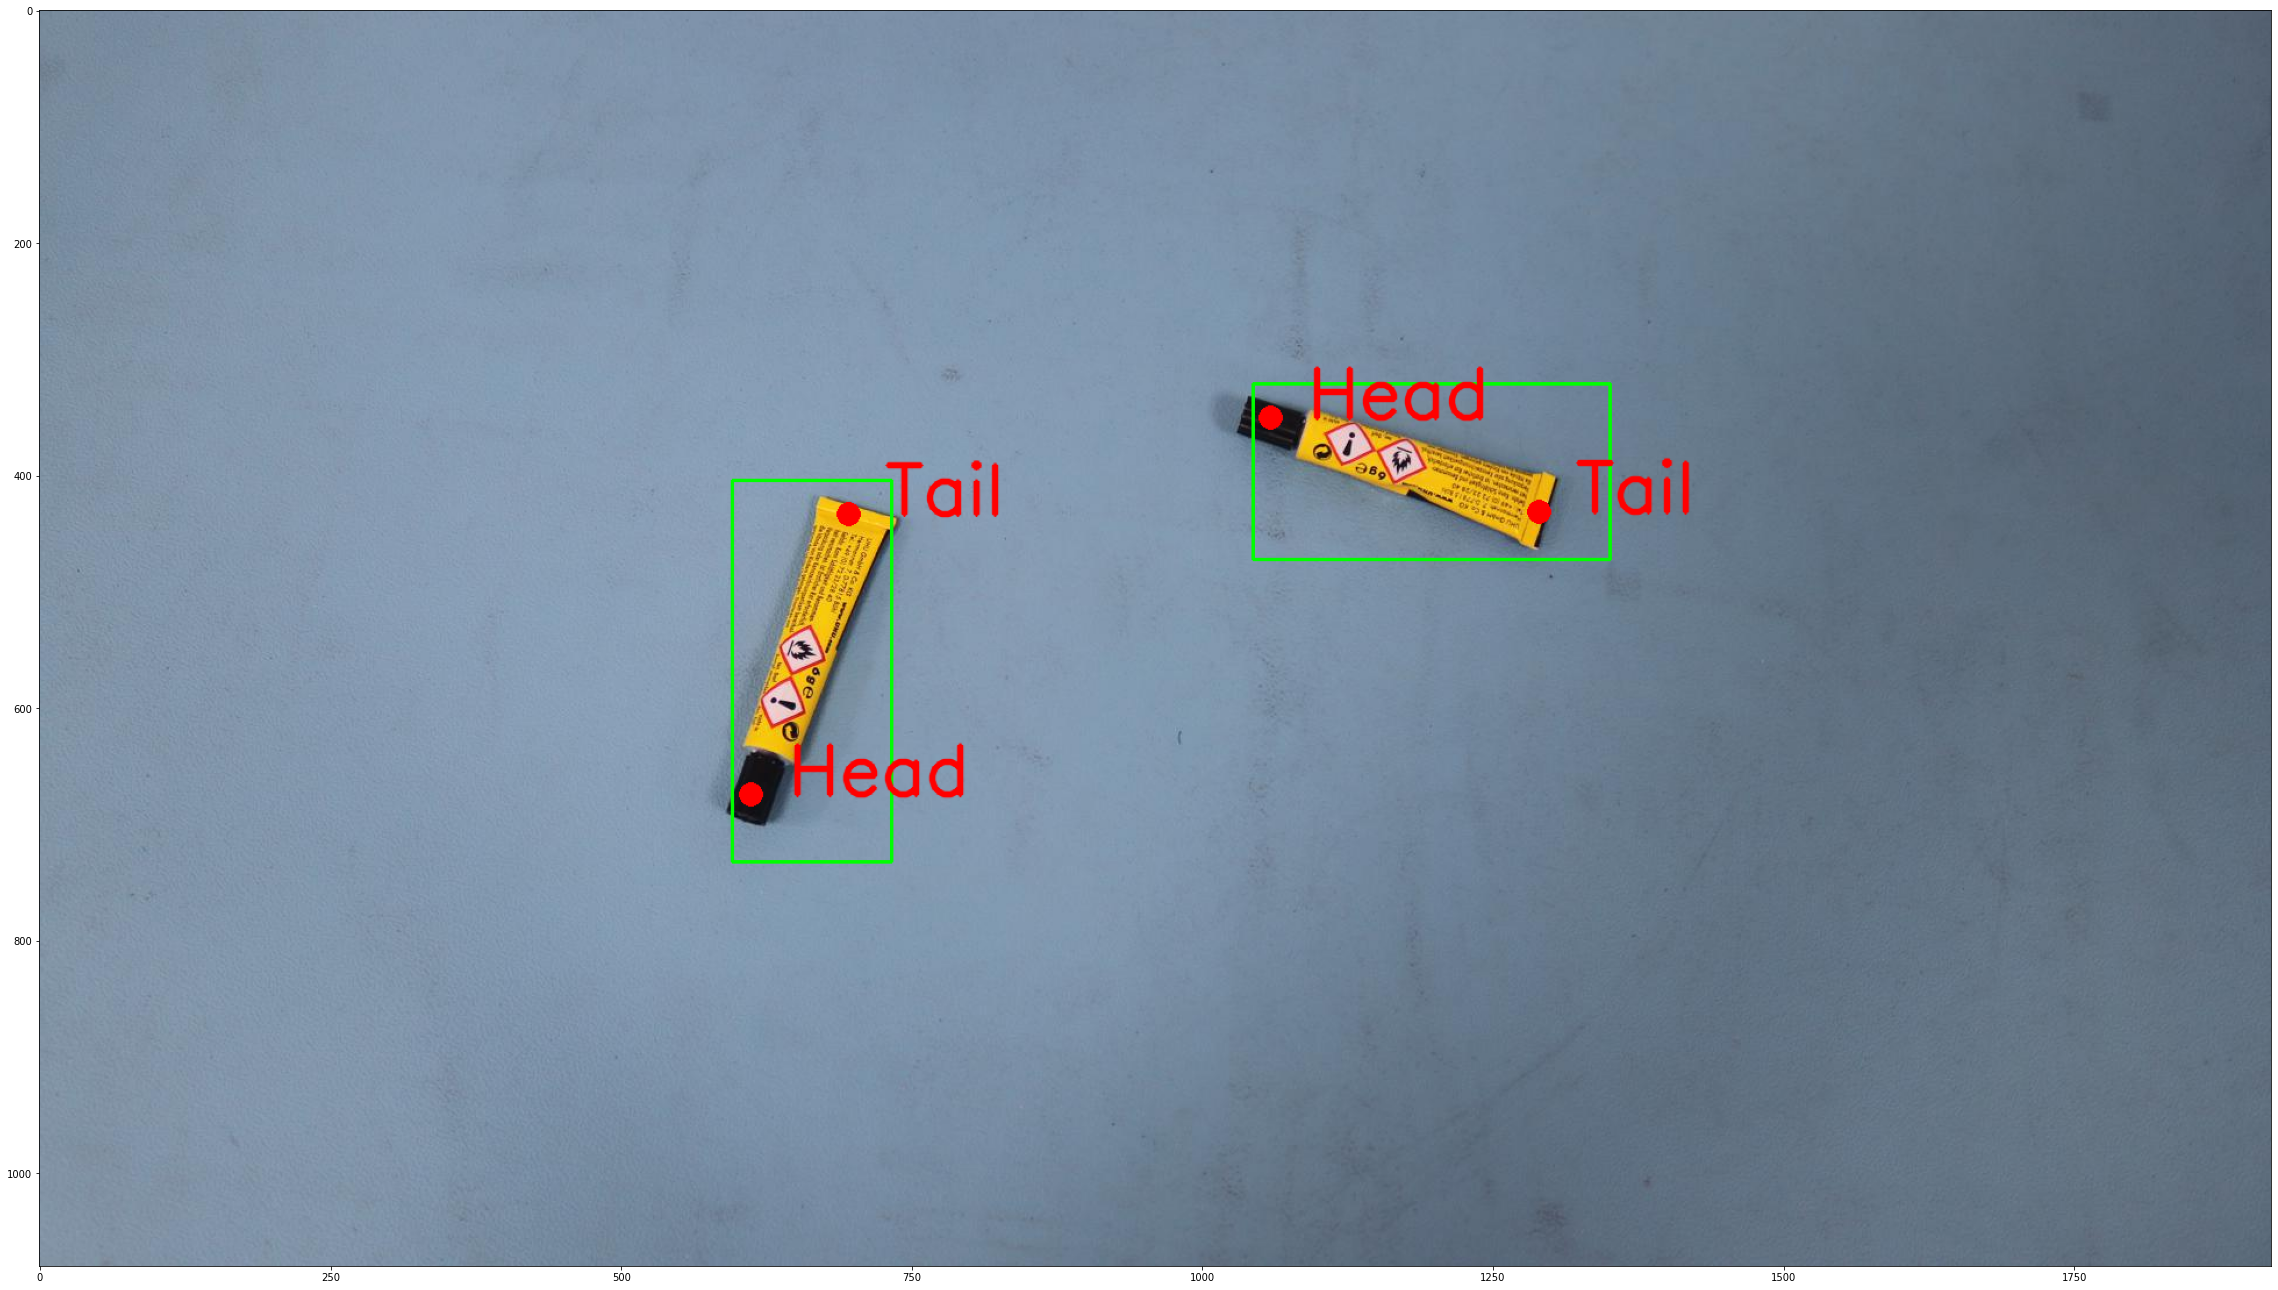

In [11]:
image = (images[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
scores = output[0]['scores'].detach().cpu().numpy()

high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

# Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
# Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
# Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

keypoints = []
for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    keypoints.append([list(map(int, kp[:2])) for kp in kps])

bboxes = []
for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))
    
visualize(image, bboxes, keypoints)

Predictions look good: bounding boxes are almost precise, keypoints are in the right places. It means the model is trained quite well.

In the same manner you can train Keypoint RCNN using another dataset, choosing any number of keypoints.